Also covers Figure 4.20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_demog_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune",
    )
    model.add_replacement_birth_flow(
        "births",
        "Susceptible",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / Parameter("life_expectancy") / 365.,
    )
    
    # Outputs
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression",
    )
    model.request_output_for_compartments(
        name="total_population",
        compartments=compartments,
    )
    model.request_output_for_compartments(
        name="susceptible_compartment",
        compartments=["Susceptible"],
    )
    model.request_output_for_compartments(
        name="immune_compartment",
        compartments=["Immune"],
    )
    total_pop = DerivedOutput("total_population")
    model.request_function_output(
        name="incidence_rate",
        func=DerivedOutput("incidence") / total_pop * 1e5,
    )
    model.request_function_output(
        name="susceptible_prop",
        func=DerivedOutput("susceptible_compartment") / total_pop,
    )
    model.request_function_output(
        name="immune_prop",
        func=DerivedOutput("immune_compartment") / total_pop,
    )
    model.request_function_output(
        name="R_n",
        func=DerivedOutput("susceptible_prop") * Parameter("r0"),
    )

    return model

In [3]:
model_config = {
    "end_time": 25550.,
    "total_population": 1e5,
    "infectious_seed": 1.,
}

parameters = {
    "latent_period": 8.,
    "infectious_period": 7.,
    "r0": 13.,
    "life_expectancy": 70.,
}

In [4]:
seir_demog_model = build_demog_model(model_config)
seir_demog_model.run(parameters=parameters)
derived_outputs = seir_demog_model.get_derived_outputs_df()
derived_outputs.index = derived_outputs.index / 365.

#### Panel a)

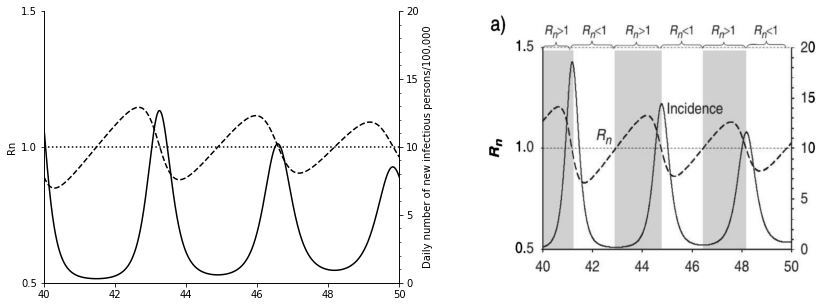

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

x_min, x_max = (40., 50.)

left_ax.plot(
    derived_outputs.index,
    derived_outputs["R_n"],
    color="k",
    linestyle="--",
)
left_ax.plot(
    (x_min, x_max),
    (1., 1.),
    color="k",
    linestyle=":",
)
left_ax.set_xlim(x_min, x_max)
left_ax.set_ylim(0.5, 1.5)
left_ax.set_yticks(np.linspace(0.5, 1.5, 3))
left_ax.set_ylabel("Rn")
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence"],
    color="k",
)
twin_ax.set_ylim(0., 20.)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_19a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

#### Panel b)
Also covers all the information presented in Figure 4.20.

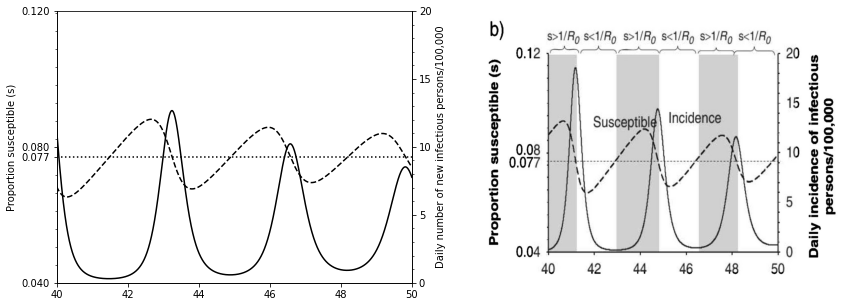

In [6]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

endemic_prop_susceptible = 1. / parameters["r0"]

left_ax.plot(
    derived_outputs.index,
    derived_outputs["susceptible_prop"],
    color="k",
    linestyle="--",
)
left_ax.plot(
    (x_min, x_max),
    (endemic_prop_susceptible, endemic_prop_susceptible),
    color="k",
    linestyle=":",
)
    
left_ax.set_xlim(x_min, x_max)
left_ax.set_ylim(0.04, 0.12)
left_ax.set_yticks((0.04, 0.077, 0.08, 0.12))
left_ax.yaxis.set_minor_locator(AutoMinorLocator(7))
left_ax.set_ylabel("Proportion susceptible (s)")
left_ax.spines.top.set_visible(False)

twin_ax = left_ax.twinx()
twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence_rate"],
    color="k",
)
twin_ax.set_ylim(0., 20.)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")

image = plt.imread("./figures/fig_4_19b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

#### Panel c)

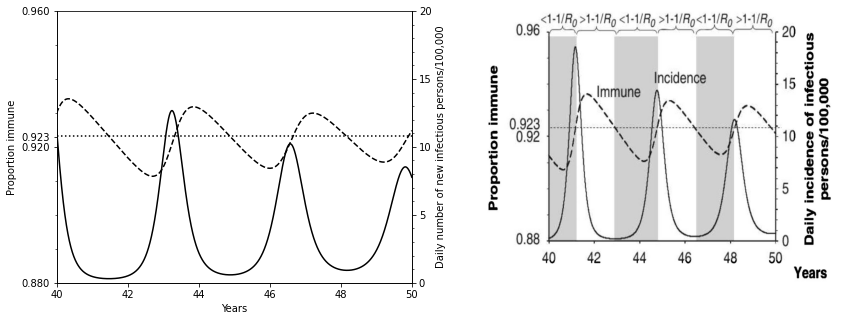

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

endemic_prop_immune = 1. - endemic_prop_susceptible

left_ax.plot(
    (x_min, x_max),
    (endemic_prop_immune, endemic_prop_immune),
    color="k",
    linestyle=":",
)
left_ax.plot(
    derived_outputs.index,
    derived_outputs["immune_prop"],
    color="k",
    linestyle="--",
)
left_ax.set_xlim(x_min, x_max)
left_ax.set_xlabel("Years")
left_ax.set_ylim(0.88, 0.96)
left_ax.set_yticks((0.88, 0.92, 0.923, 0.96))
left_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.set_ylabel("Proportion immune")
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence_rate"],
    color="k",
)
twin_ax.set_ylim(0., 20.)
twin_ax.set_yticks(range(0, 25, 5))
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")

image = plt.imread("./figures/fig_4_19c.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");